In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# Get the data.

dimuon = pd.read_csv('http://opendata.cern.ch/record/545/files/Dimuon_DoubleMu.csv')

In [ ]:
# This is a very simple version that only detects the highest peak.

# First we define what part and how precisely we are looking at the data.

step = int(input('How many GeVs should our step be (1 should do)? '))
start = int(input('From what GeV shall we start (0 or over is good)? '))
end = int(input('How far shall we look at (120 is probably fine)? '))

print('\n')

bins = int((end-start)/step)

hist, edges = np.histogram(dimuon.M[(dimuon.M <= end) & (dimuon.M >= start)], bins)

# For statistical purposes, let's break our data to smaller pieces for the analysis.

medians = np.ones(len(edges)-1)
modes = np.ones(len(edges)-1)

for i in range (0,len(edges)-1):
    cut = dimuon.M[(dimuon.M >= start)&(dimuon.M < (start + step))]
    start = start + step
    breakdown, precision = np.histogram(cut, bins = 10)
    print('The median of events in step ' + str(i) + ' is: ' + str(np.median(breakdown)))
    print('The mode of events in step ' + str(i) + ' is: ' + str(max(breakdown)) + '\n')
    medians[i] = np.median(breakdown)
    modes[i] = max(breakdown)
    
plt.plot(medians, 'r*', label = 'Medians')
plt.plot(modes, 'vb', label = 'Modes')
plt.legend()
plt.show()

In [3]:
# This is a pretty powerful translation of a Matlab-function to python.

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

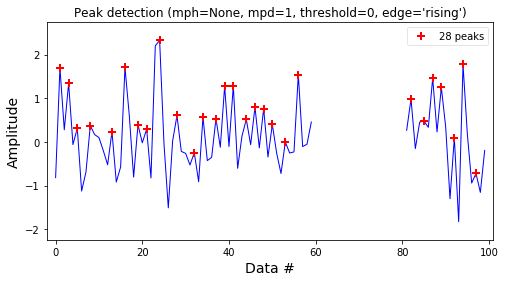

[ 1  3  5  8 13 16 19 21 24 28 32 34 37 39 41 44 46 48 50 53 56 82 85 87
 89 92 94 97]


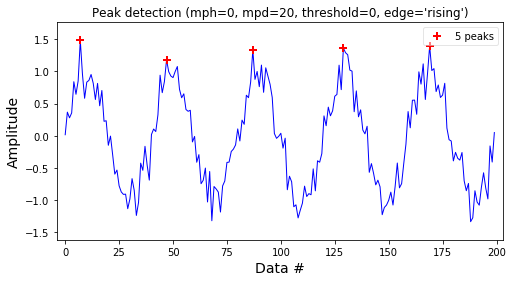

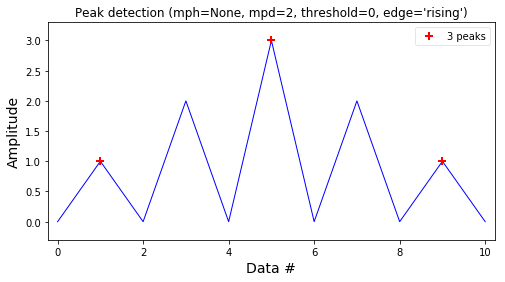

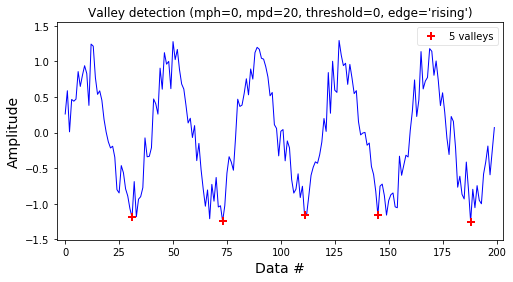

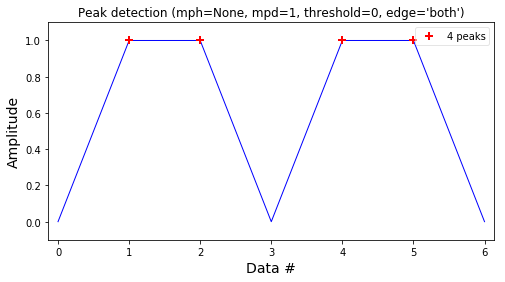

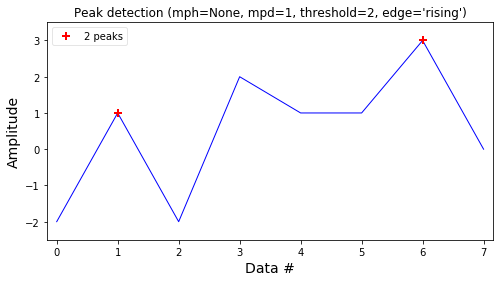

array([1, 6], dtype=int64)

In [4]:
# This cell contains random tests for the finder function.

x = np.random.randn(100)
x[60:81] = np.nan
# detect all peaks and plot data
ind = detect_peaks(x, show=True)
print(ind)

x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
# set minimum peak height = 0 and minimum peak distance = 20
detect_peaks(x, mph=0, mpd=20, show=True)

x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
# set minimum peak distance = 2
detect_peaks(x, mpd=2, show=True)

x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
# detection of valleys instead of peaks
detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

x = [0, 1, 1, 0, 1, 1, 0]
# detect both edges
detect_peaks(x, edge='both', show=True)

x = [-2, 1, -2, 2, 1, 1, 3, 0]
# set threshold = 2
detect_peaks(x, threshold = 2, show=True)

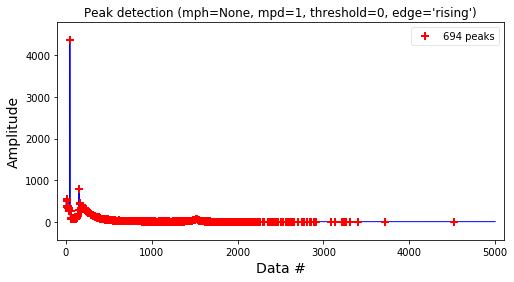

[   8   12   14   17   20   24   26   29   31   34   38   40   43   46
   56   59   64   66   70   74   76   79   84   87   89   91   93   98
  104  106  108  110  113  116  120  123  125  127  131  133  138  140
  144  153  157  162  167  173  175  177  180  182  187  189  193  195
  197  200  202  204  207  210  213  216  220  225  228  231  234  236
  238  240  243  245  250  253  256  258  261  263  266  268  272  277
  279  283  287  289  292  297  299  302  304  310  313  316  320  322
  325  328  333  336  338  342  345  348  350  353  356  359  362  364
  367  371  374  376  378  381  383  389  392  395  397  401  405  408
  412  414  417  419  422  425  427  431  433  436  440  444  446  448
  450  452  454  456  459  463  465  467  470  473  477  479  483  485
  488  490  495  497  500  503  505  507  509  513  516  519  522  525
  527  529  531  534  536  538  544  547  550  553  555  557  561  564
  566  569  572  574  578  583  586  590  596  599  602  604  607  609
  612 

In [6]:
# This is an ugly "everything goes" run for our data.

hist, edges = np.histogram(dimuon.M, bins = 5000)

# detect all peaks and plot data
ind = detect_peaks(hist, show=True)
print(ind)

How many GeVs should our step be (1 should do)? 1
From what GeV shall we start (0 or over is good)? 0
How far shall we look at (120 is probably fine)? 120


On step 0 with 10 steps the peaks look like this: 


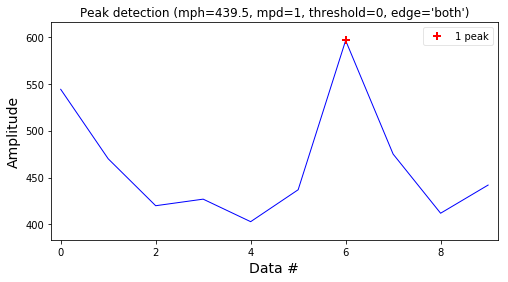

[6]


On step 1 with 10 steps the peaks look like this: 


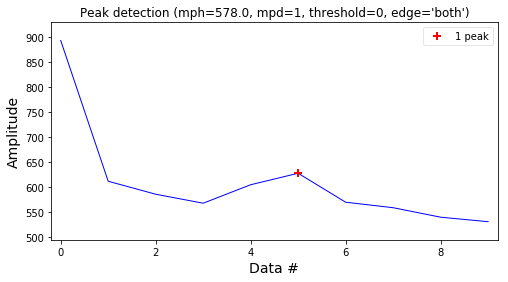

[5]


On step 2 with 10 steps the peaks look like this: 


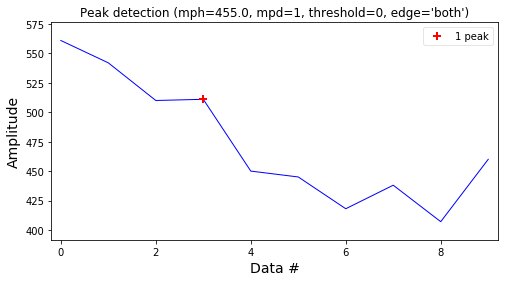

[3]


On step 3 with 10 steps the peaks look like this: 


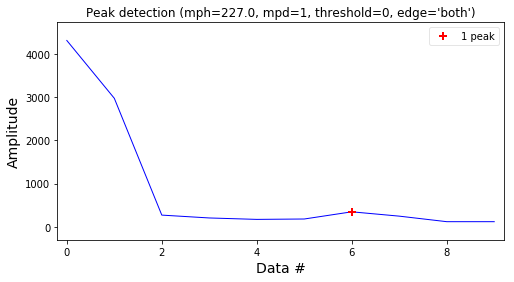

[6]


On step 4 with 10 steps the peaks look like this: 


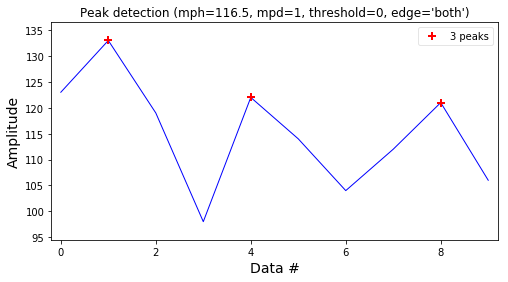

[1 4 8]


On step 5 with 10 steps the peaks look like this: 


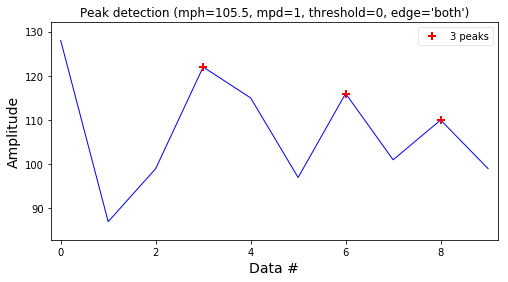

[3 6 8]


On step 6 with 10 steps the peaks look like this: 


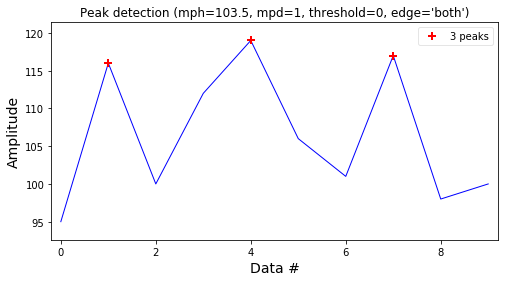

[1 4 7]


On step 7 with 10 steps the peaks look like this: 


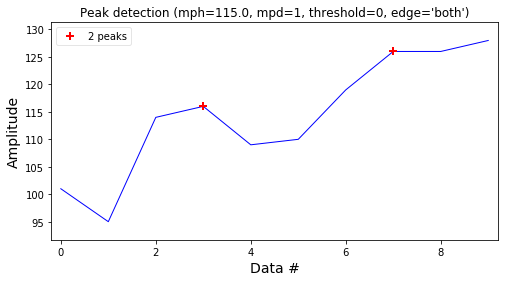

[3 7]


On step 8 with 10 steps the peaks look like this: 


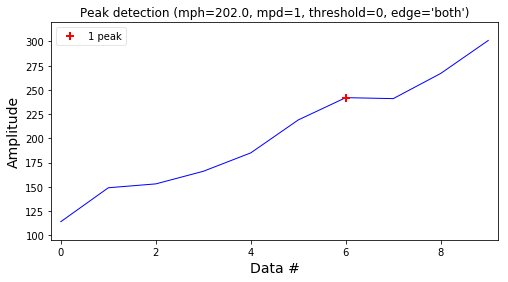

[6]


On step 9 with 10 steps the peaks look like this: 


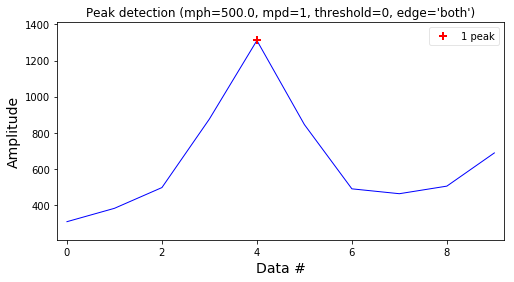

[4]


On step 10 with 10 steps the peaks look like this: 


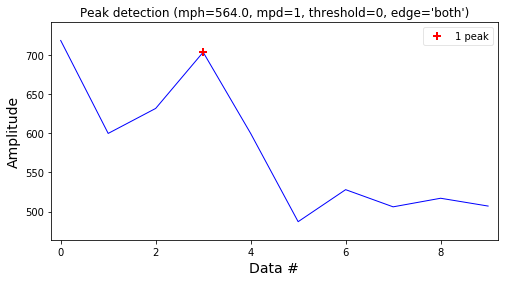

[3]


On step 11 with 10 steps the peaks look like this: 


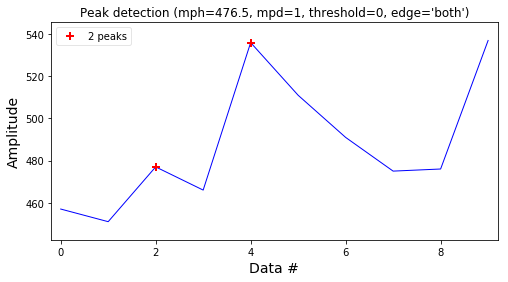

[2 4]


On step 12 with 10 steps the peaks look like this: 


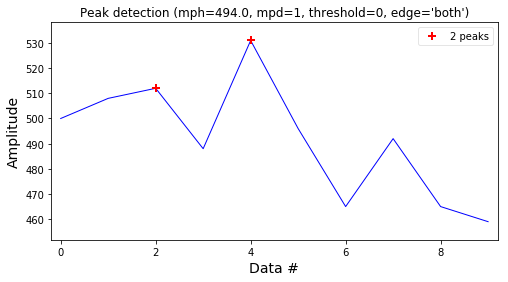

[2 4]


On step 13 with 10 steps the peaks look like this: 


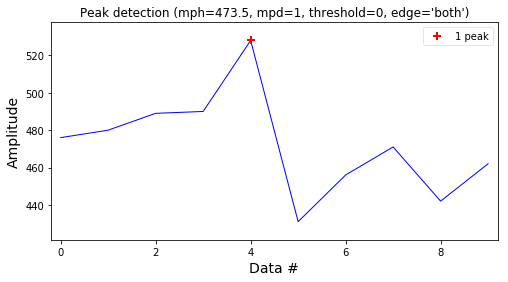

[4]


On step 14 with 10 steps the peaks look like this: 


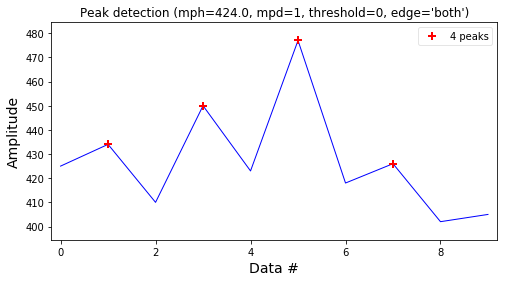

[1 3 5 7]


On step 15 with 10 steps the peaks look like this: 


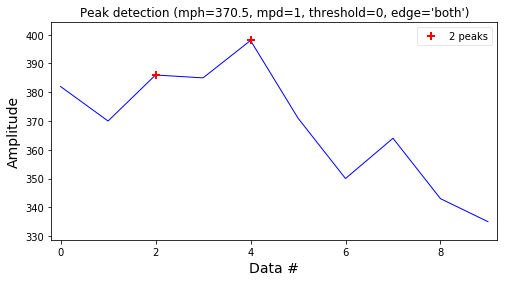

[2 4]


On step 16 with 10 steps the peaks look like this: 


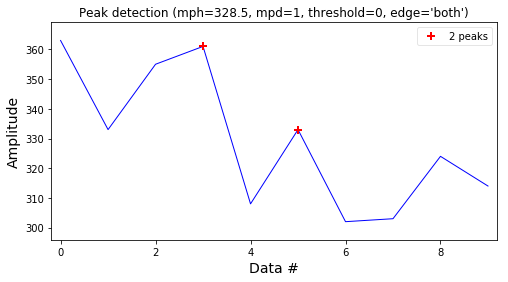

[3 5]


On step 17 with 10 steps the peaks look like this: 


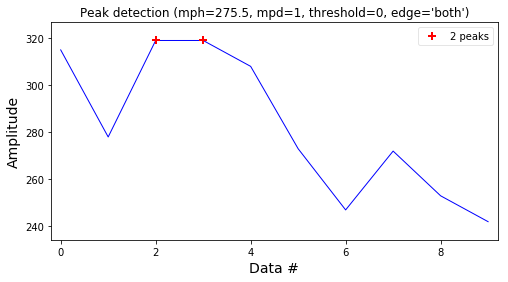

[2 3]


On step 18 with 10 steps the peaks look like this: 


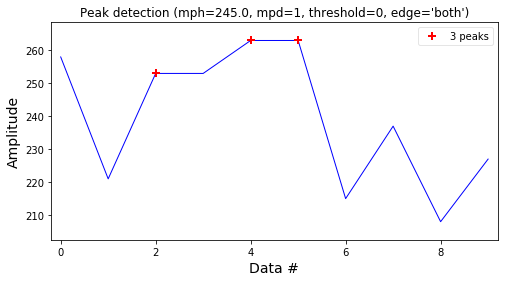

[2 4 5]


On step 19 with 10 steps the peaks look like this: 


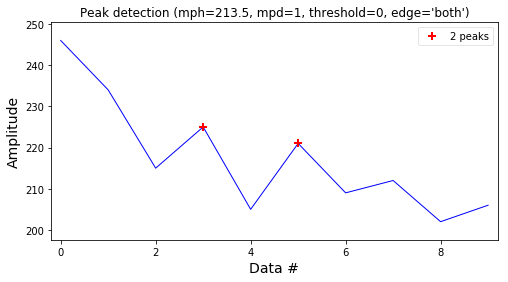

[3 5]


On step 20 with 10 steps the peaks look like this: 


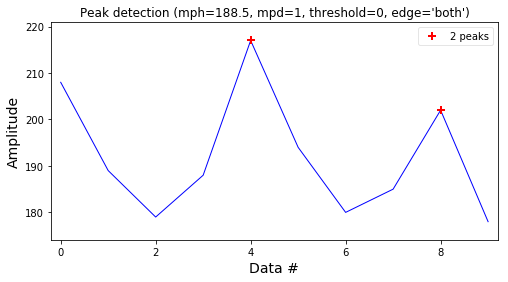

[4 8]


On step 21 with 10 steps the peaks look like this: 


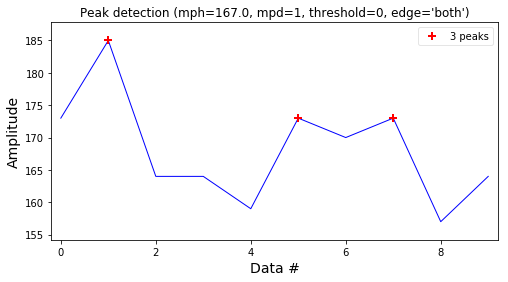

[1 5 7]


On step 22 with 10 steps the peaks look like this: 


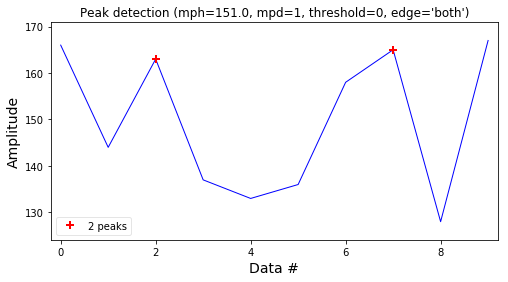

[2 7]


On step 23 with 10 steps the peaks look like this: 


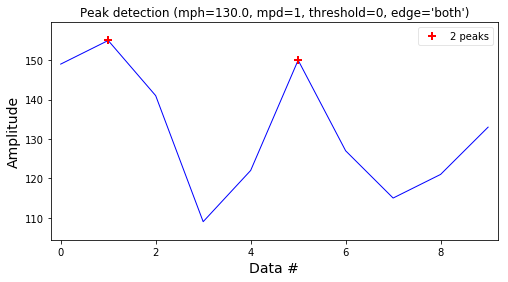

[1 5]


On step 24 with 10 steps the peaks look like this: 


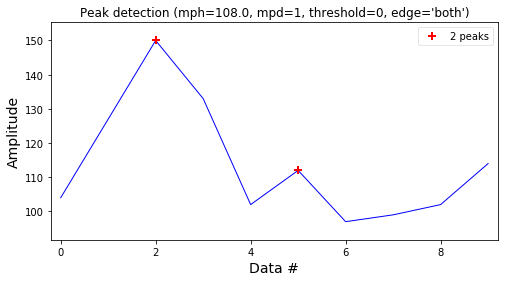

[2 5]


On step 25 with 10 steps the peaks look like this: 


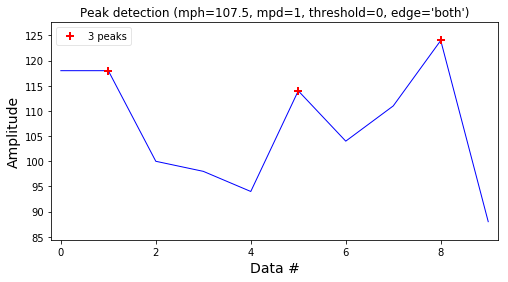

[1 5 8]


On step 26 with 10 steps the peaks look like this: 


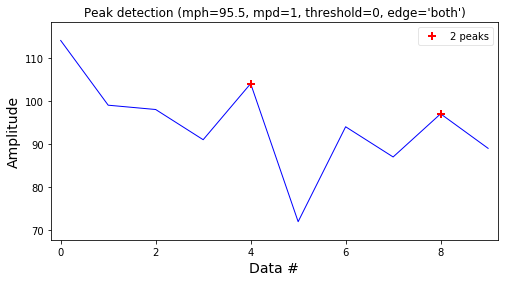

[4 8]


On step 27 with 10 steps the peaks look like this: 


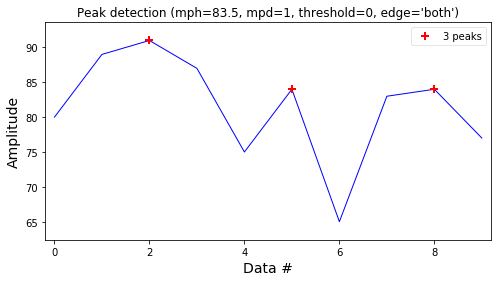

[2 5 8]


On step 28 with 10 steps the peaks look like this: 


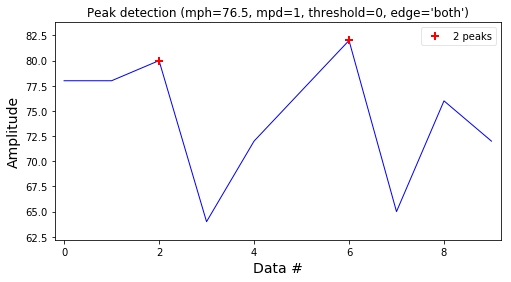

[2 6]


On step 29 with 10 steps the peaks look like this: 


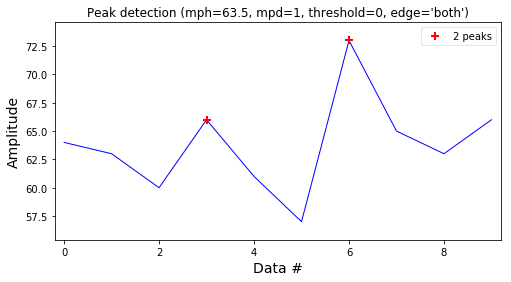

[3 6]


On step 30 with 10 steps the peaks look like this: 


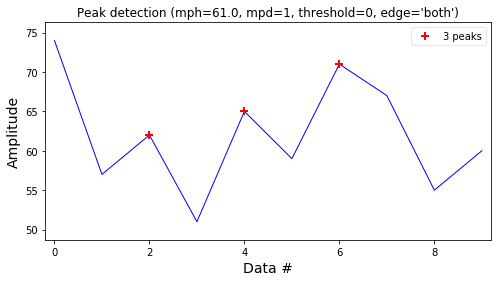

[2 4 6]


On step 31 with 10 steps the peaks look like this: 


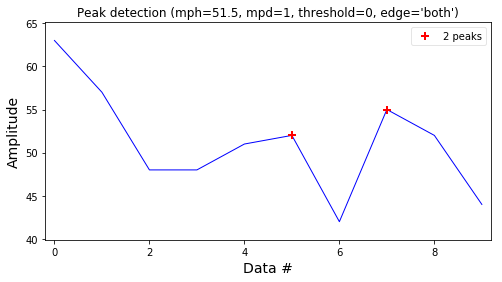

[5 7]


On step 32 with 10 steps the peaks look like this: 


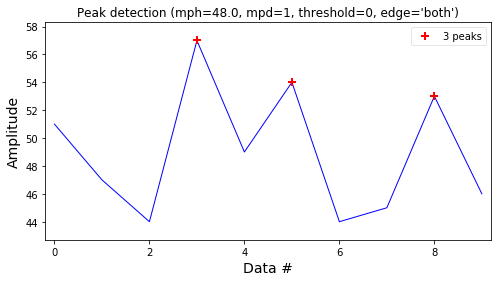

[3 5 8]


On step 33 with 10 steps the peaks look like this: 


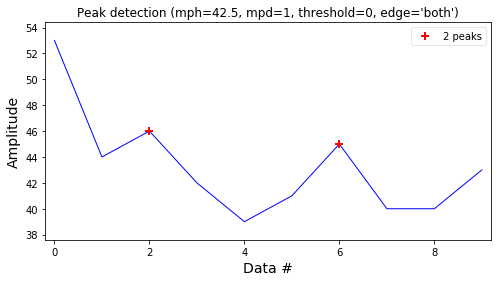

[2 6]


On step 34 with 10 steps the peaks look like this: 


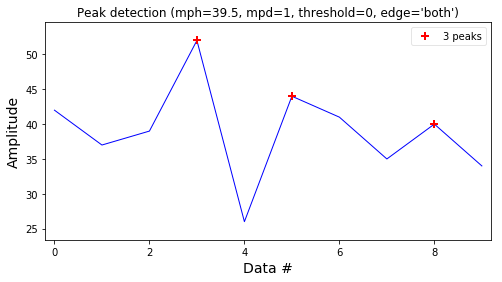

[3 5 8]


On step 35 with 10 steps the peaks look like this: 


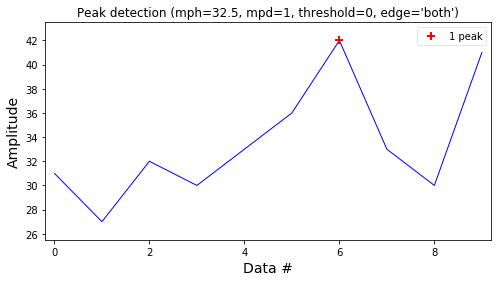

[6]


On step 36 with 10 steps the peaks look like this: 


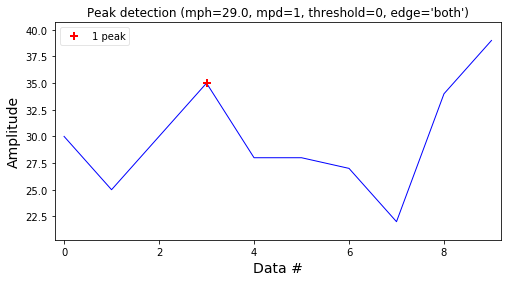

[3]


On step 37 with 10 steps the peaks look like this: 


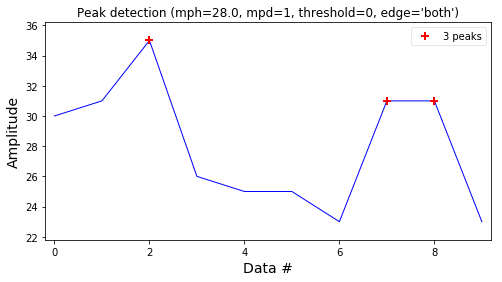

[2 7 8]


On step 38 with 10 steps the peaks look like this: 


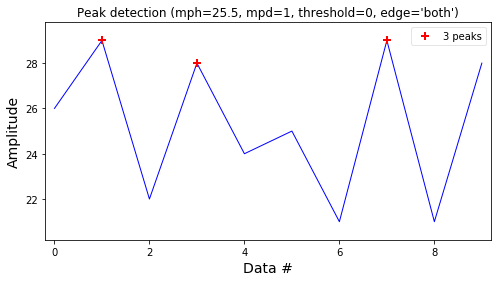

[1 3 7]


On step 39 with 10 steps the peaks look like this: 


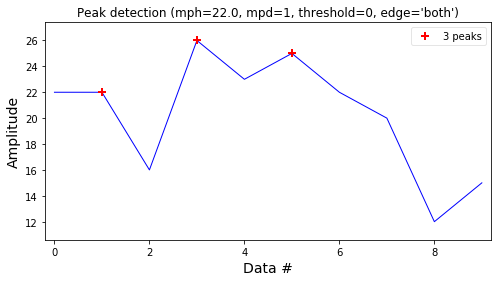

[1 3 5]


On step 40 with 10 steps the peaks look like this: 


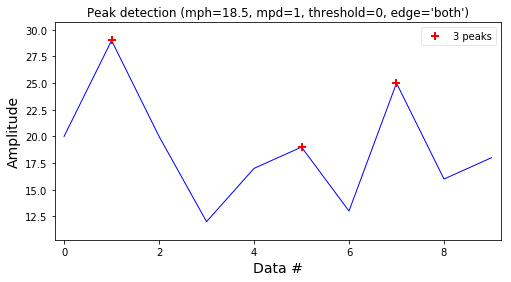

[1 5 7]


On step 41 with 10 steps the peaks look like this: 


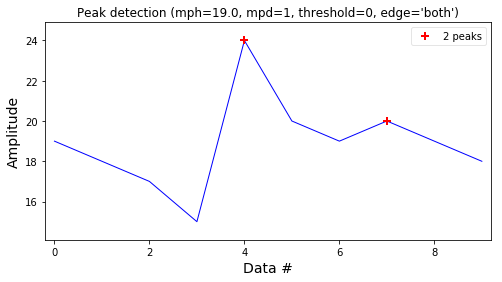

[4 7]


On step 42 with 10 steps the peaks look like this: 


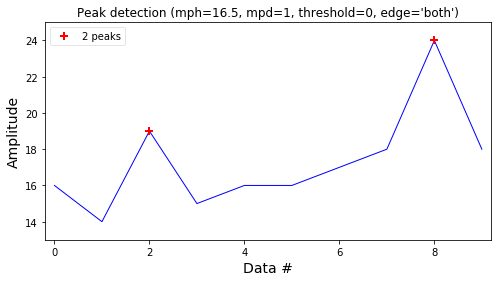

[2 8]


On step 43 with 10 steps the peaks look like this: 


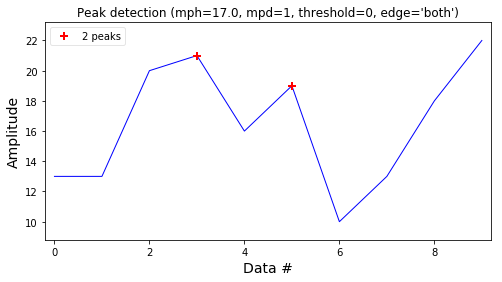

[3 5]


On step 44 with 10 steps the peaks look like this: 


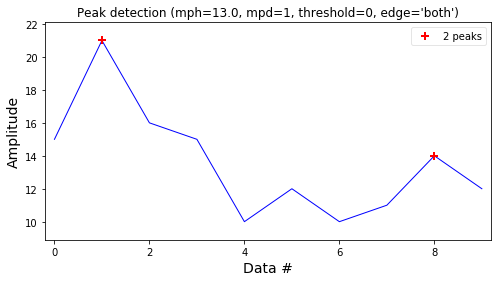

[1 8]


On step 45 with 10 steps the peaks look like this: 


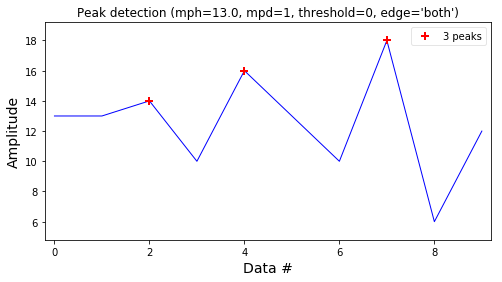

[2 4 7]


On step 46 with 10 steps the peaks look like this: 


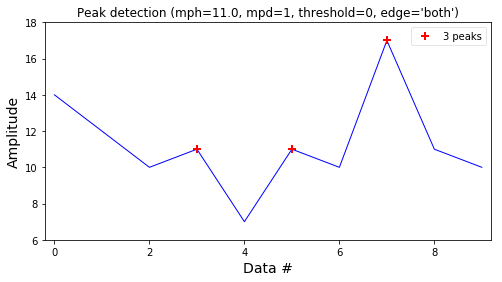

[3 5 7]


On step 47 with 10 steps the peaks look like this: 


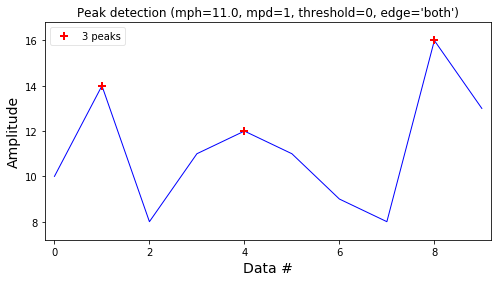

[1 4 8]


On step 48 with 10 steps the peaks look like this: 


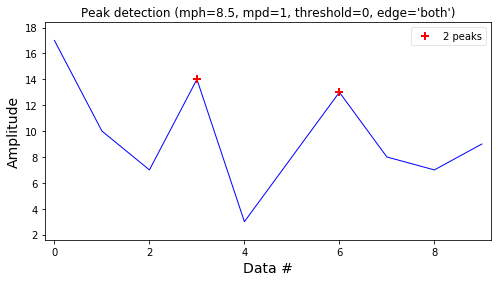

[3 6]


On step 49 with 10 steps the peaks look like this: 


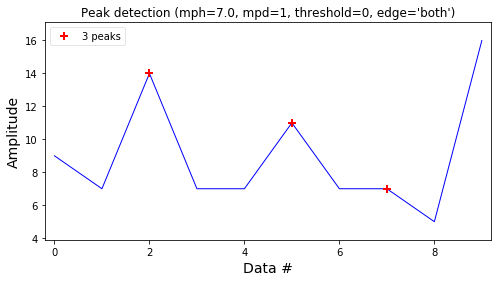

[2 5 7]


On step 50 with 10 steps the peaks look like this: 


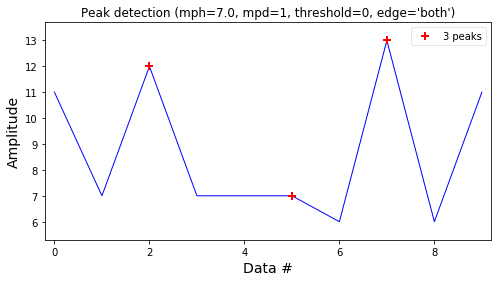

[2 5 7]


On step 51 with 10 steps the peaks look like this: 


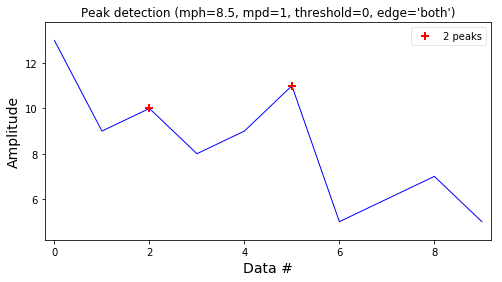

[2 5]


On step 52 with 10 steps the peaks look like this: 


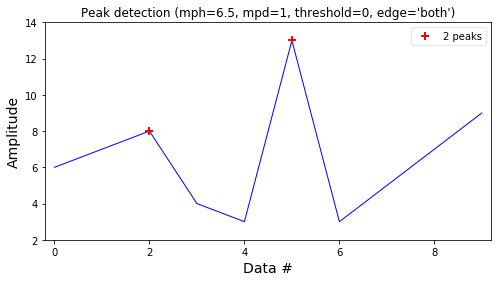

[2 5]


On step 53 with 10 steps the peaks look like this: 


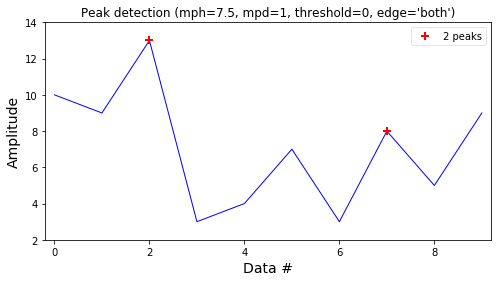

[2 7]


On step 54 with 10 steps the peaks look like this: 


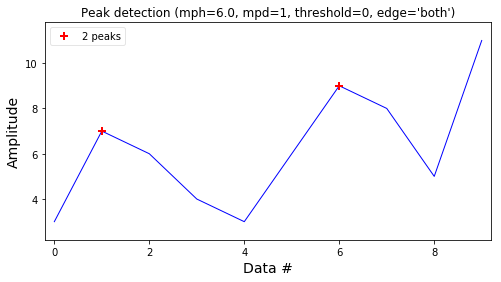

[1 6]


On step 55 with 10 steps the peaks look like this: 


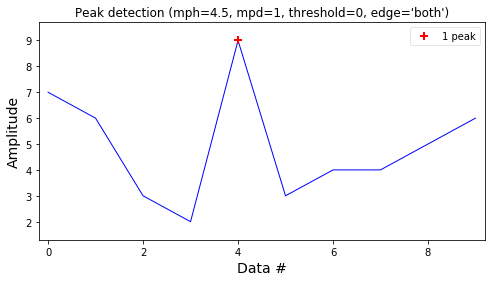

[4]


On step 56 with 10 steps the peaks look like this: 


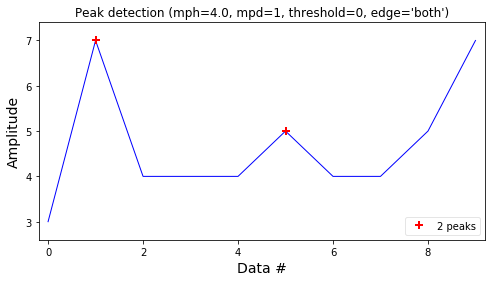

[1 5]


On step 57 with 10 steps the peaks look like this: 


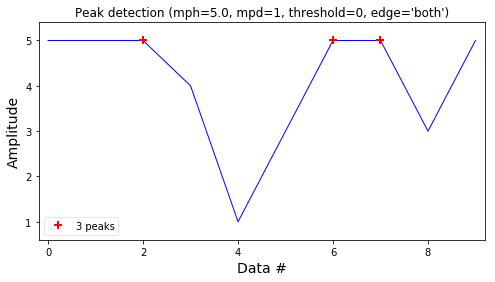

[2 6 7]


On step 58 with 10 steps the peaks look like this: 


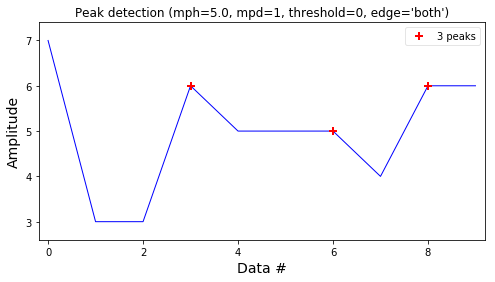

[3 6 8]


On step 59 with 10 steps the peaks look like this: 


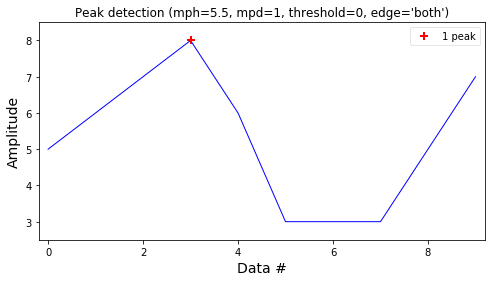

[3]


On step 60 with 10 steps the peaks look like this: 


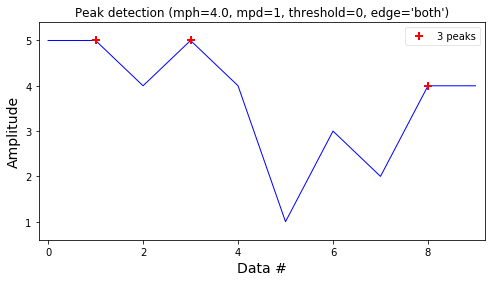

[1 3 8]


On step 61 with 10 steps the peaks look like this: 


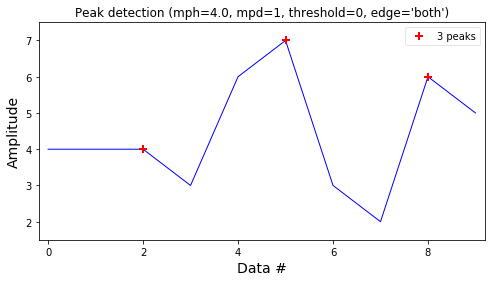

[2 5 8]


On step 62 with 10 steps the peaks look like this: 


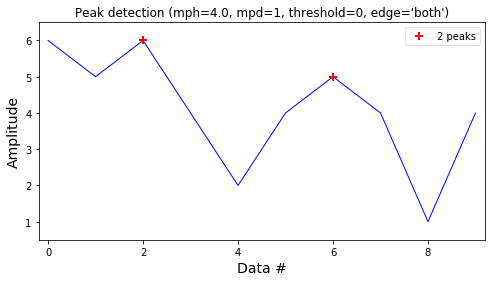

[2 6]


On step 63 with 10 steps the peaks look like this: 


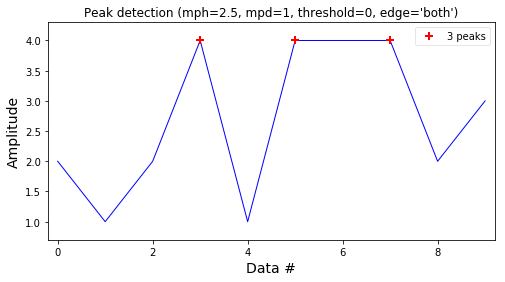

[3 5 7]


On step 64 with 10 steps the peaks look like this: 


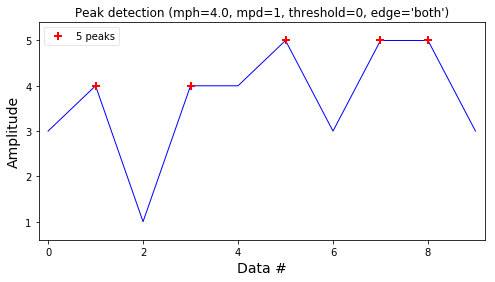

[1 3 5 7 8]


On step 65 with 10 steps the peaks look like this: 


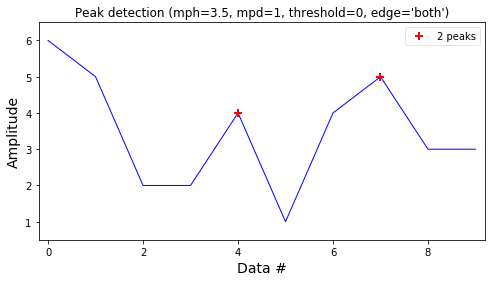

[4 7]


On step 66 with 10 steps the peaks look like this: 


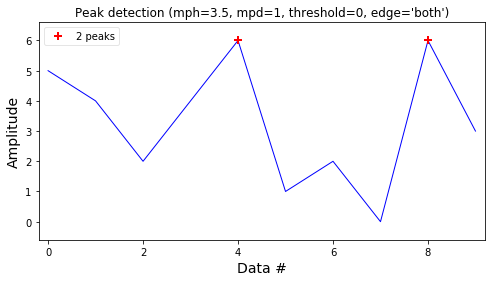

[4 8]


On step 67 with 10 steps the peaks look like this: 


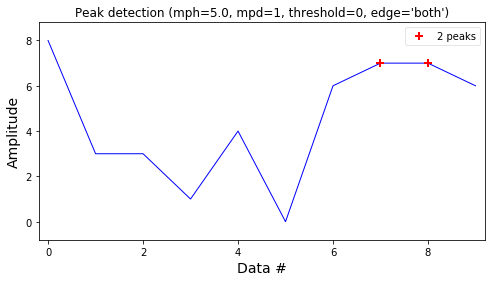

[7 8]


On step 68 with 10 steps the peaks look like this: 


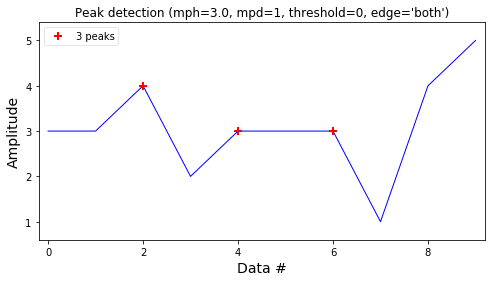

[2 4 6]


On step 69 with 10 steps the peaks look like this: 


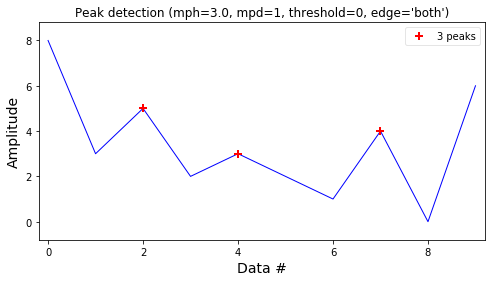

[2 4 7]


On step 70 with 10 steps the peaks look like this: 


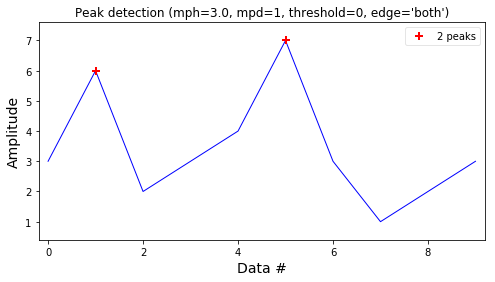

[1 5]


On step 71 with 10 steps the peaks look like this: 


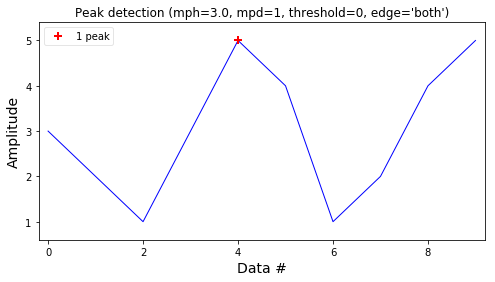

[4]


On step 72 with 10 steps the peaks look like this: 


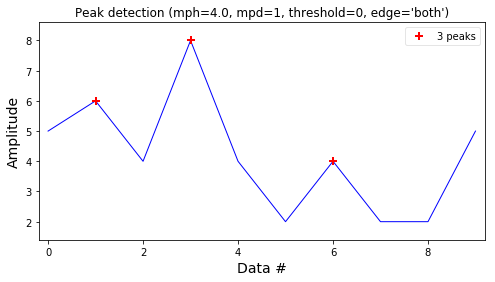

[1 3 6]


On step 73 with 10 steps the peaks look like this: 


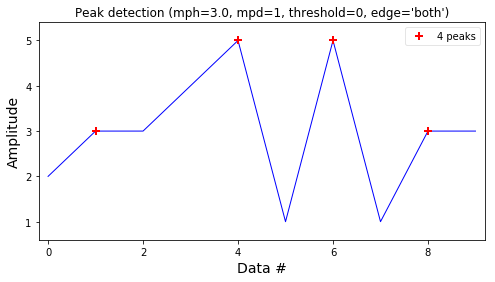

[1 4 6 8]


On step 74 with 10 steps the peaks look like this: 


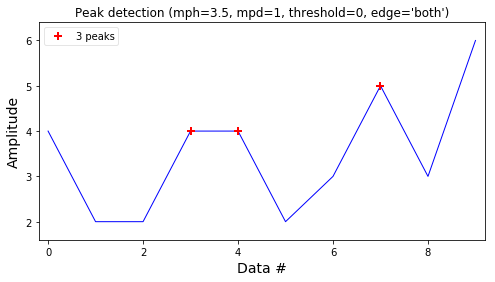

[3 4 7]


On step 75 with 10 steps the peaks look like this: 


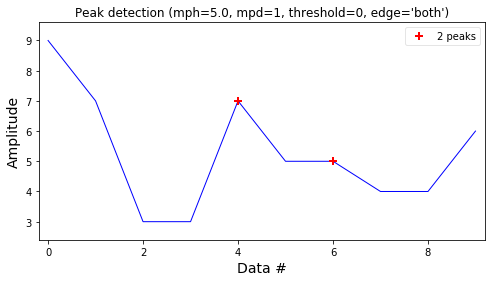

[4 6]


On step 76 with 10 steps the peaks look like this: 


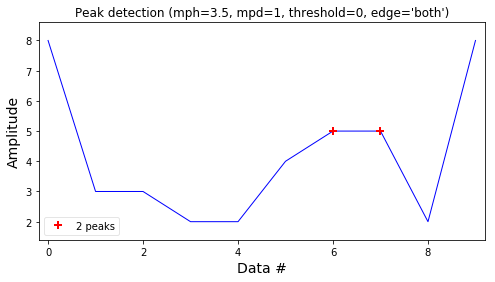

[6 7]


On step 77 with 10 steps the peaks look like this: 


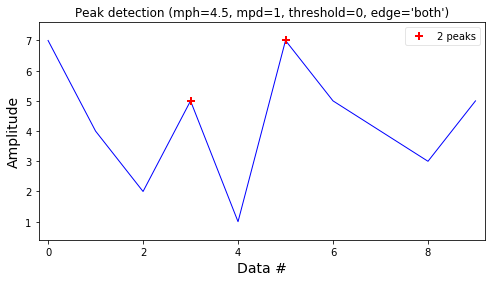

[3 5]


On step 78 with 10 steps the peaks look like this: 


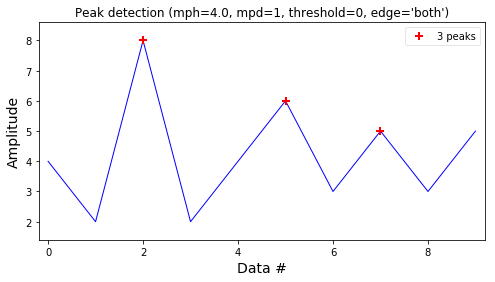

[2 5 7]


On step 79 with 10 steps the peaks look like this: 


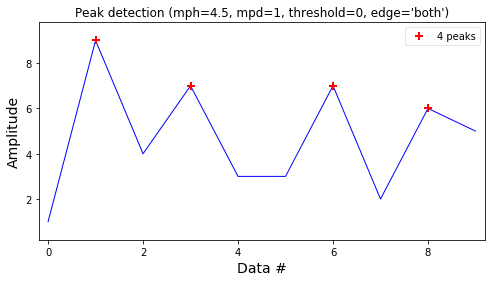

[1 3 6 8]


On step 80 with 10 steps the peaks look like this: 


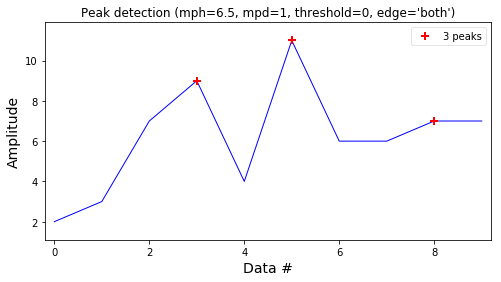

[3 5 8]


On step 81 with 10 steps the peaks look like this: 


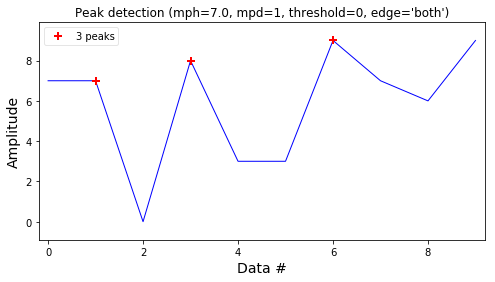

[1 3 6]


On step 82 with 10 steps the peaks look like this: 


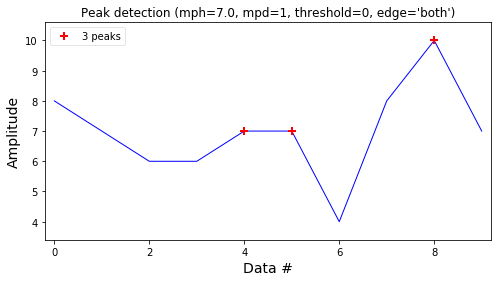

[4 5 8]


On step 83 with 10 steps the peaks look like this: 


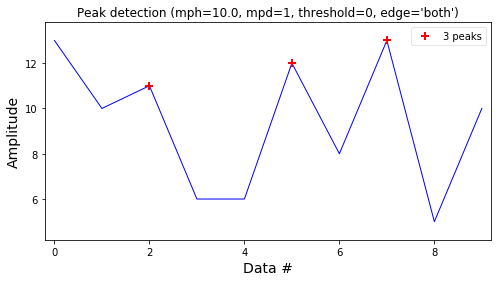

[2 5 7]


On step 84 with 10 steps the peaks look like this: 


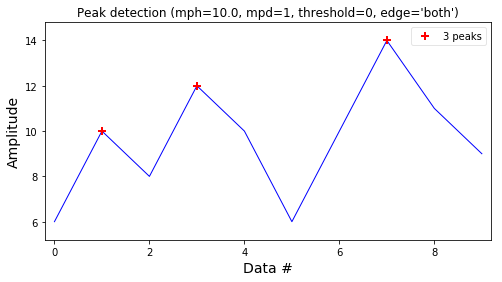

[1 3 7]


On step 85 with 10 steps the peaks look like this: 


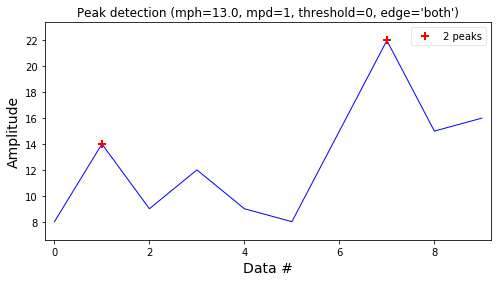

[1 7]


On step 86 with 10 steps the peaks look like this: 


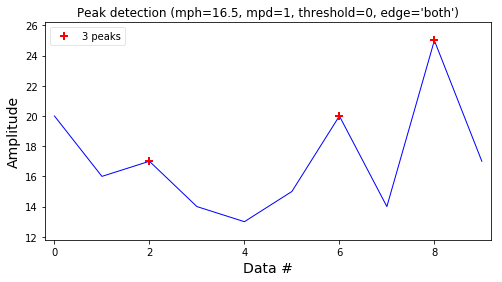

[2 6 8]


On step 87 with 10 steps the peaks look like this: 


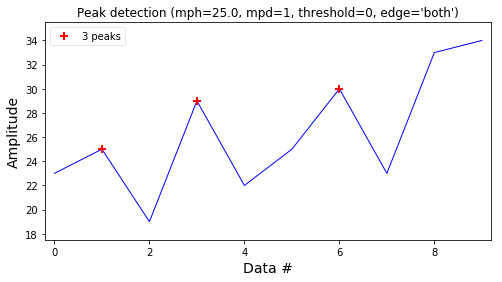

[1 3 6]


On step 88 with 10 steps the peaks look like this: 


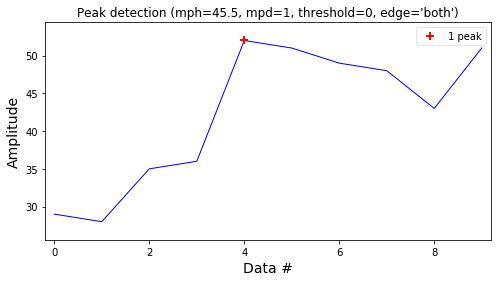

[4]


On step 89 with 10 steps the peaks look like this: 


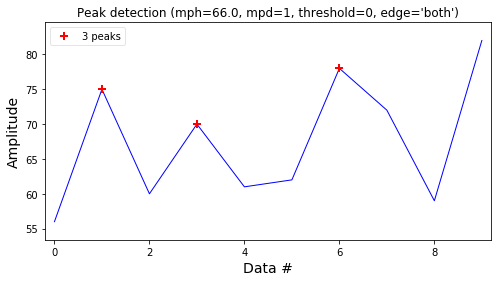

[1 3 6]


On step 90 with 10 steps the peaks look like this: 


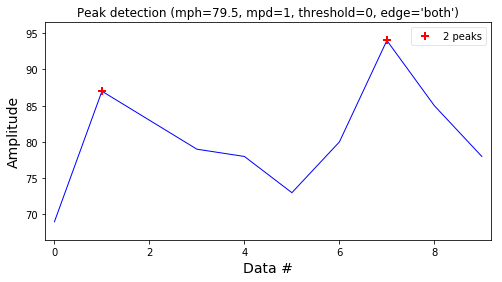

[1 7]


On step 91 with 10 steps the peaks look like this: 


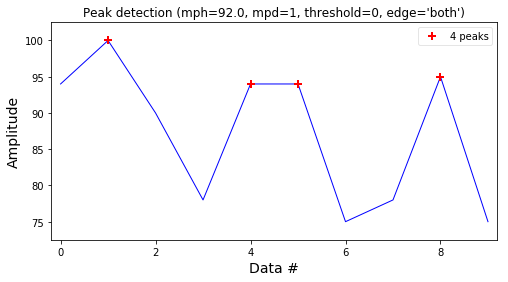

[1 4 5 8]


On step 92 with 10 steps the peaks look like this: 


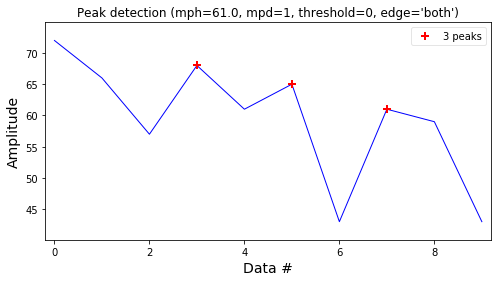

[3 5 7]


On step 93 with 10 steps the peaks look like this: 


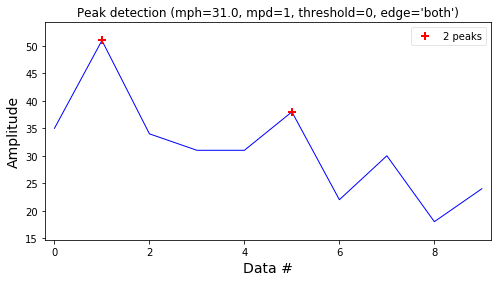

[1 5]


On step 94 with 10 steps the peaks look like this: 


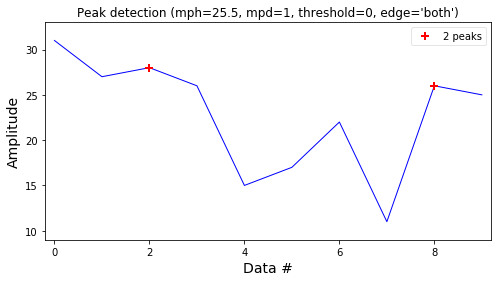

[2 8]


On step 95 with 10 steps the peaks look like this: 


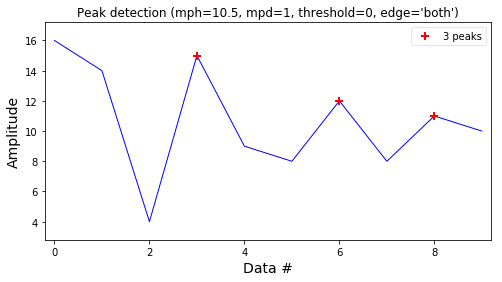

[3 6 8]


On step 96 with 10 steps the peaks look like this: 


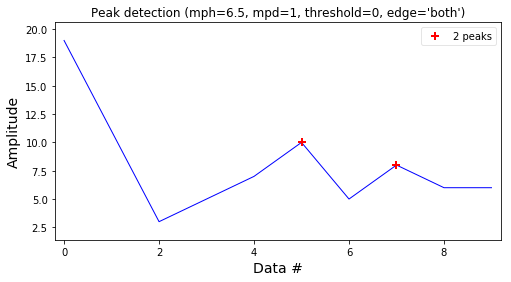

[5 7]


On step 97 with 10 steps the peaks look like this: 


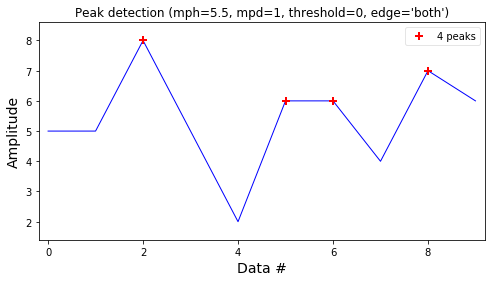

[2 5 6 8]


On step 98 with 10 steps the peaks look like this: 


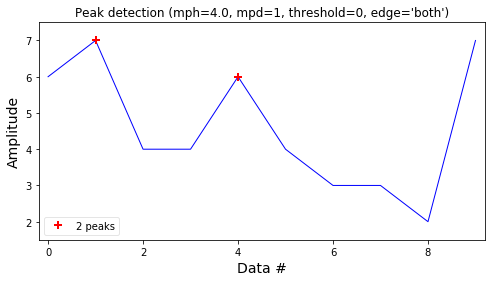

[1 4]


On step 99 with 10 steps the peaks look like this: 


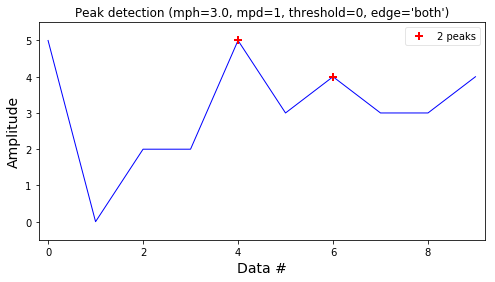

[4 6]


On step 100 with 10 steps the peaks look like this: 


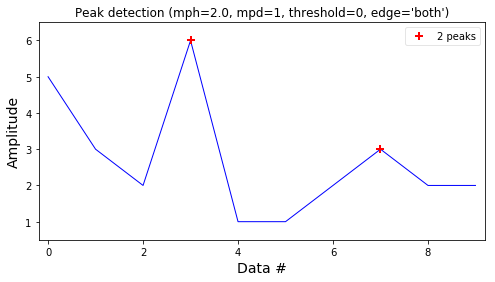

[3 7]


On step 101 with 10 steps the peaks look like this: 


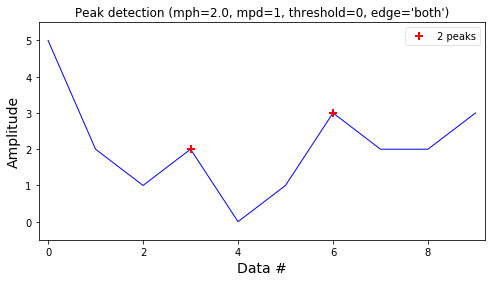

[3 6]


On step 102 with 10 steps the peaks look like this: 


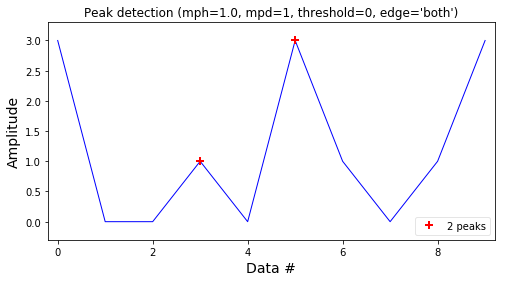

[3 5]


On step 103 with 10 steps the peaks look like this: 


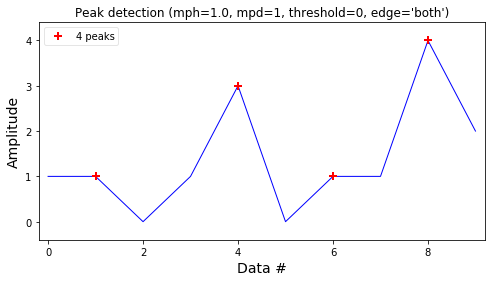

[1 4 6 8]


On step 104 with 10 steps the peaks look like this: 


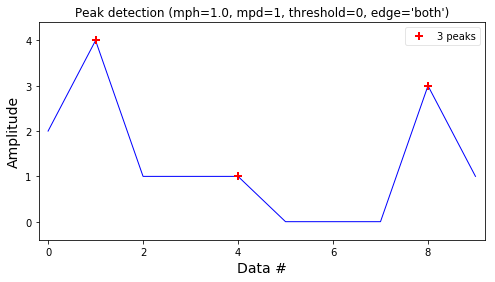

[1 4 8]


On step 105 with 10 steps the peaks look like this: 


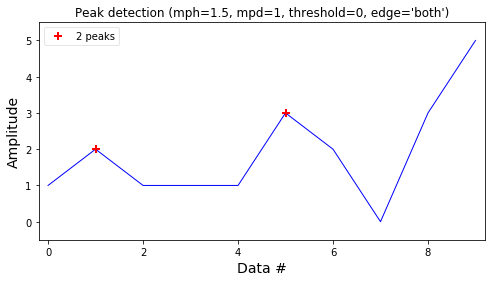

[1 5]


On step 106 with 10 steps the peaks look like this: 


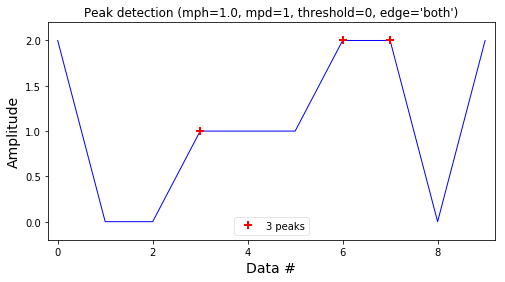

[3 6 7]


On step 107 with 10 steps the peaks look like this: 


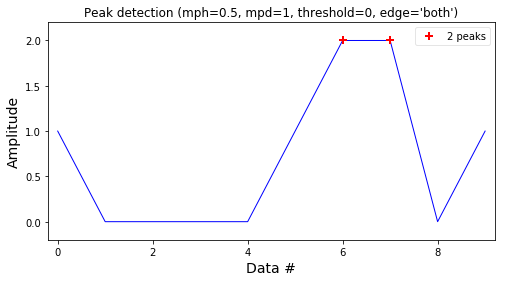

[6 7]


On step 108 with 10 steps the peaks look like this: 


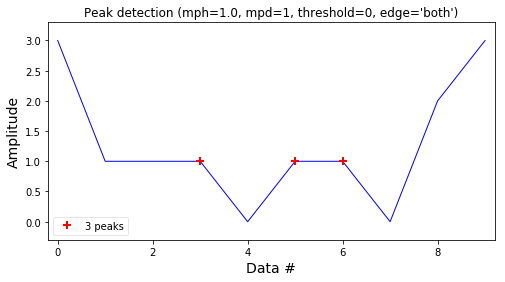

[3 5 6]


On step 109 with 10 steps the peaks look like this: 


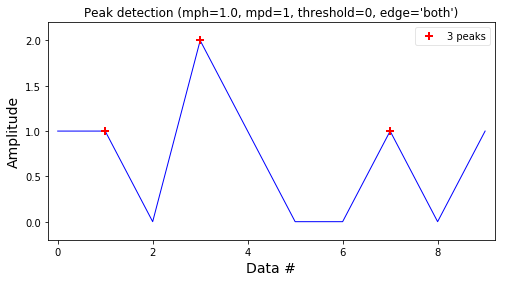

[1 3 7]


On step 110 with 10 steps the peaks look like this: 


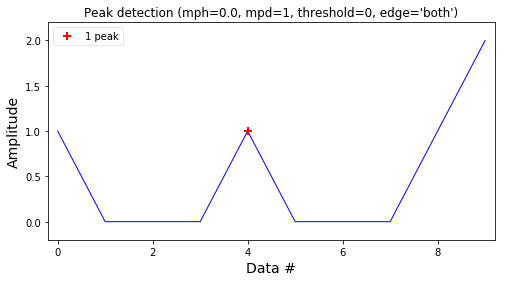

[4]


On step 111 with 10 steps the peaks look like this: 


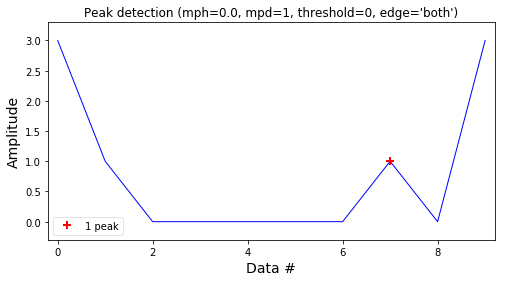

[7]


On step 112 with 10 steps the peaks look like this: 


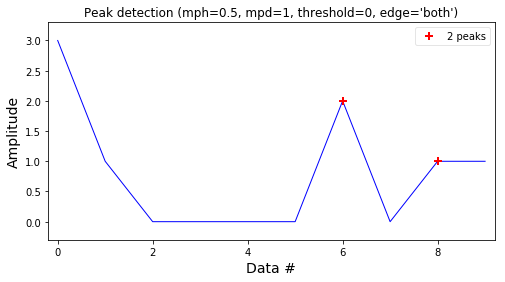

[6 8]


On step 113 with 10 steps the peaks look like this: 


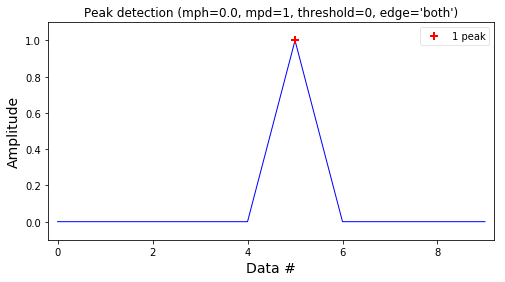

[5]


On step 114 with 10 steps the peaks look like this: 


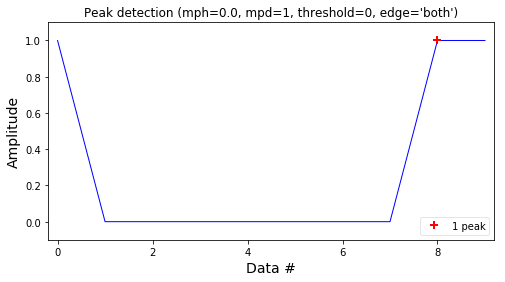

[8]


On step 115 with 10 steps the peaks look like this: 


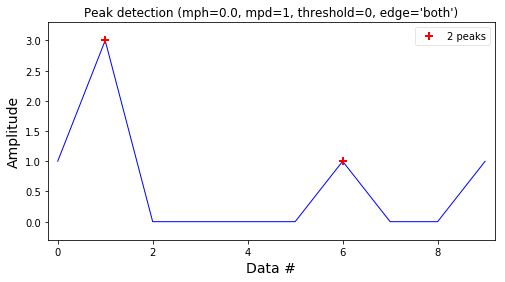

[1 6]


On step 116 with 10 steps the peaks look like this: 


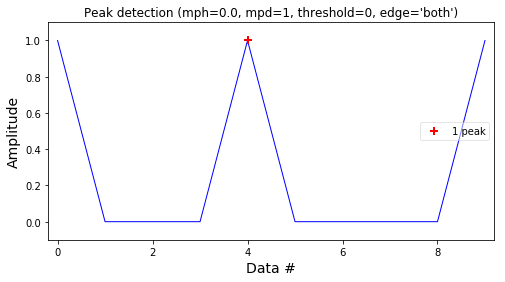

[4]


On step 117 with 10 steps the peaks look like this: 


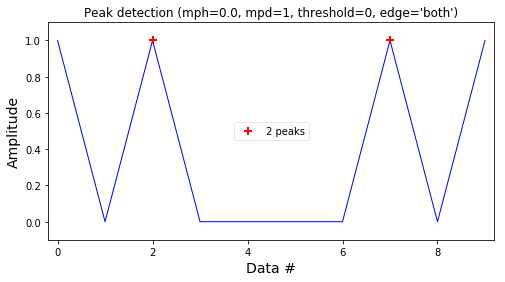

[2 7]


On step 118 with 10 steps the peaks look like this: 


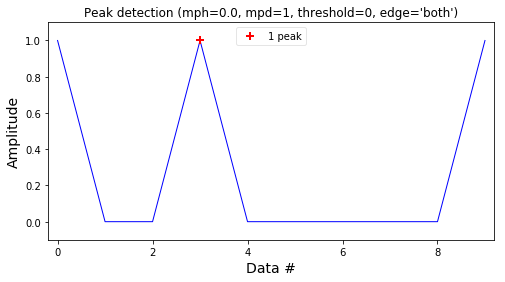

[3]


On step 119 with 10 steps the peaks look like this: 


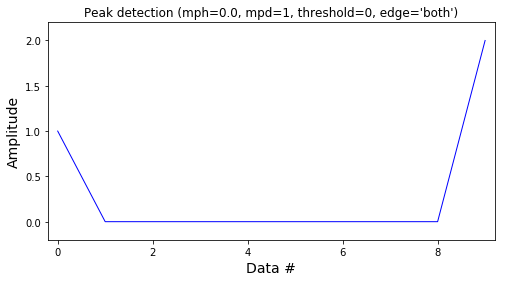

[]




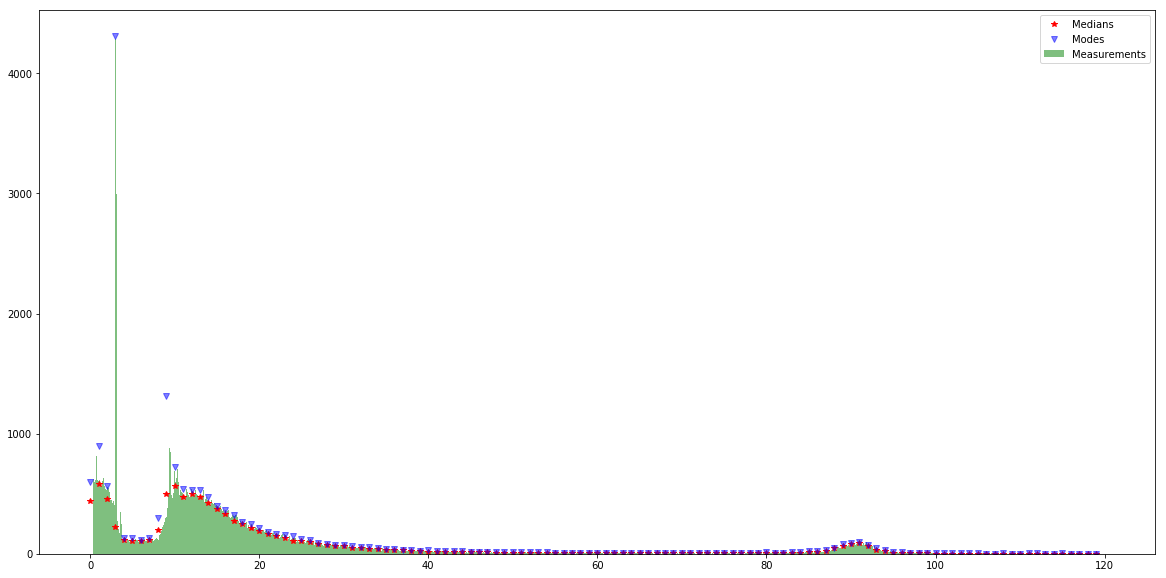

In [16]:
# Here we try to merge these ideas and produce a step by step reading of our data with more
# precision than simply taking the highest peak.

step = int(input('How many GeVs should our step be (1 should do)? '))
start = int(input('From what GeV shall we start (0 or over is good)? '))
end = int(input('How far shall we look at (120 is probably fine)? '))

print('\n')

bins = int((end-start)/step)

hist, edges = np.histogram(dimuon.M[(dimuon.M <= end) & (dimuon.M >= start)], bins)

# For statistical purposes, let's break our data to smaller pieces for the analysis.

medians = np.ones(len(edges)-1)
modes = np.ones(len(edges)-1)

for i in range (0,len(edges)-1):
    cut = dimuon.M[(dimuon.M >= start)&(dimuon.M < (start + step))]
    start = start + step
    a = 10
    breakdown, precision = np.histogram(cut, bins = a)
    #print('The median of events in step ' + str(i) + ' is: ' + str(np.median(breakdown)))
    #print('The mode of events in step ' + str(i) + ' is: ' + str(max(breakdown)) + '\n')
    print('On step %i with %a steps the peaks look like this: ' % (i,a))
    ind = detect_peaks(breakdown, mph = np.median(breakdown), show=True, edge = 'both')
    print(ind)
    print('\n')
    medians[i] = np.median(breakdown)
    modes[i] = max(breakdown)

plt.figure(figsize = (20,10))
plt.hist(dimuon.M, bins*a, alpha = 0.5, color = 'green', label = 'Measurements', range = (0, end))
plt.plot(medians, 'r*', label = 'Medians')
plt.plot(modes, 'vb', label = 'Modes', alpha = 0.5)
plt.legend()
plt.show()